E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?


E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [1]:
# E01 - 729 inputs 27 outputs

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

words = open('names.txt').read().splitlines()
words

FileNotFoundError: [Errno 2] No such file or directory: 'names.txt'

In [3]:
# conversion dicts
all_chs =(['.'] + sorted(set(''.join(words))))
cross = [(x,y) for x in all_chs for y in all_chs]
dstoi = {v:k for k,v in enumerate(cross)}
stoi = {v:k for k,v in enumerate(all_chs)}
itos = {v:k for k,v in stoi.items()}

# load training set
xs, ys = [],[]
for word in words:
    chs = ['.','.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:],chs[2:]):
        # print(ch1,ch2,ch3, dstoi[(ch1,ch2)], stoi[ch3])
        xs.append(dstoi[(ch1,ch2)])
        ys.append(stoi[ch3])

# print(xs,ys)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

In [4]:
# initalise the model
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*27,27), generator=g, requires_grad=True)
W.shape

torch.Size([729, 27])

0 3.8028223514556885
10 2.9728496074676514
20 2.751415491104126
30 2.639045476913452
40 2.5677452087402344
50 2.5173239707946777
60 2.4795491695404053
70 2.4501521587371826
80 2.4266247749328613
90 2.4073612689971924
100 2.391273021697998
110 2.3776063919067383
120 2.3658294677734375
130 2.3555636405944824
140 2.3465304374694824
150 2.3385188579559326
160 2.3313658237457275
170 2.3249423503875732
180 2.319143533706665
190 2.3138835430145264
final loss after 200 iterations: 2.309551477432251


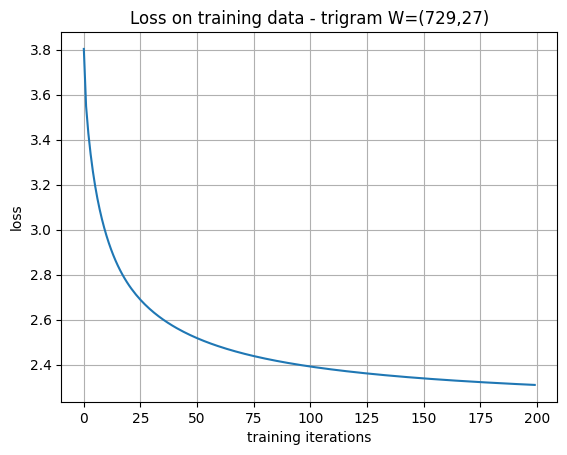

In [5]:
N_ITER = 10
LEARN_RATE = 100
C = 0.01

losses = []
for i in range(N_ITER):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27*27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)

    # works out loss
    loss = -probs[torch.arange(num), ys].log().mean() + C * (W**2).mean()
    losses.append(loss.data)
    # print(i, loss.data)
    
    # re-zero grads and backward pass to get gradients
    W.grad = None
    loss.backward()
    if i % 10 == 0:
        print(i, loss.item())
    
    # update the model weighgrts
    W.data += -LEARN_RATE * W.grad

print(f"final loss after {N_ITER} iterations: {losses[-1]}")
plt.xlabel("training iterations")
plt.ylabel("loss")
plt.title("Loss on training data - trigram W=(729,27)")
plt.grid()
plt.plot(losses)

In [6]:
# Generate words
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    word = []
    ix1, ix2 = 0, 0
    while True:
        ix = dstoi[itos[ix1],itos[ix2]]
        iy = torch.multinomial(probs[ix], num_samples = 1, replacement=True, generator=g).item()
        word.append(itos[iy])
        if iy == 0:
            break
        ix1, ix2 = ix2, iy
    print(''.join(word))

junndedna.
asah.
pslfaahnin.
avshinlnolemaejrennadninta.
yaaileviai.
dbdnilrwymol.
sniyieay.
arha.
fnrtumtkifodaumj.
pfnnelennesazjrcore.


In [9]:
# E04 remove requirement for one hot en-coding

In [7]:
words = open('names.txt').read().splitlines()

In [32]:
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {v:k for k,v in enumerate(chars)}
itos = {v:k for k,v in stoi.items()}

In [79]:
# load training data
xs, ys = [],[]
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs, ys = torch.tensor(xs), torch.tensor(ys)
xs_num = xs.nelement()

In [120]:
# initalise weights in model
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [121]:
# normalise function added to penalise when the Weight are large, we are pulling them back to be zero
NUM_ITER = 100
C = 0.01
LEARN_RATE = 10
losses = []
for i in range(NUM_ITER):
    # forward pass

    # replace one hot and matmul with just selecting rows from the weight based on the index of the input
    # xenc = F.one_hot(xs, num_classes=27).float()
    # logits = xenc @ W
    logits = W[xs]
    
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(xs_num), ys].log().mean() + C * (W**2).mean()
    losses.append(loss.data)
    if i % 10 == 0:
        print(i, loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # recalculate
    W.data += -LEARN_RATE * W.grad
losses[-1].item()

0 3.768618583679199
10 3.1869826316833496
20 2.9516518115997314
30 2.8283956050872803
40 2.753448009490967
50 2.7026009559631348
60 2.665598154067993
70 2.637566328048706
80 2.6157853603363037
90 2.5985164642333984


2.5858423709869385

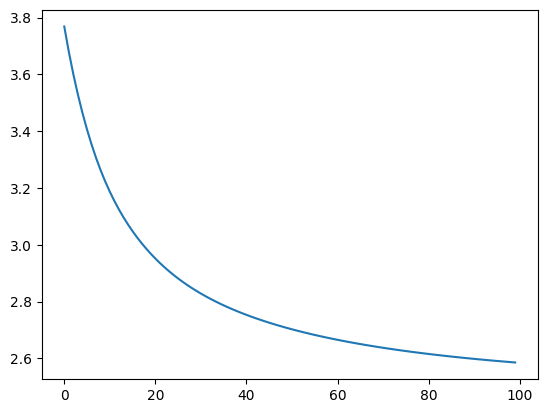

In [116]:
plt.plot(losses)

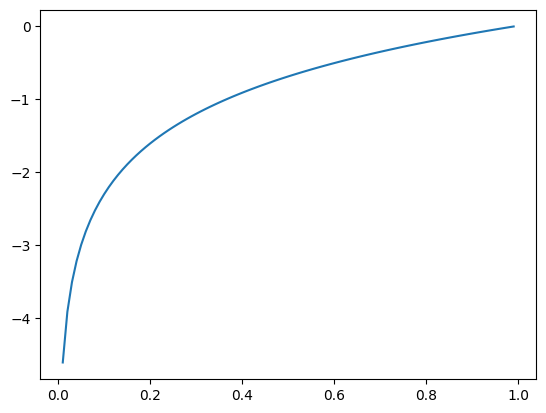

In [69]:
# why do we use a log - we penalise more heavily when the prob is low, which means the loss is greater
x = torch.arange(0,1,0.01)
plt.plot(x, torch.log(x))

In [ ]:
# cross entropy


In [122]:
# initalise weights in model
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [8]:
input = torch.randn(3,5,requires_grad=True)
input

tensor([[ 0.8012,  0.8836, -1.0017, -0.2066,  1.1762],
        [-0.6577,  0.5803, -0.5491,  1.7958,  0.5151],
        [-0.7511,  1.2484, -0.3396,  1.0059, -0.4875]], requires_grad=True)

In [16]:
target = torch.empty(3, dtype=torch.long).random_(5)

In [17]:
target

tensor([3, 4, 0])

In [21]:
loss = torch.nn.CrossEntropyLoss()
output = loss(input, target)
output

tensor(2.3627, grad_fn=<NllLossBackward0>)

In [32]:
counts = input.exp()
probs = counts / counts.sum(1, keepdim=True)
-probs[torch.arange(3),target].log().mean()

tensor(2.3627, grad_fn=<NegBackward0>)

In [ ]:
# CrossEntropyLoss is a shortcut to: 
# taking the exp(), work out probs for each row, log() and mean() and * -1